# Unsaturated Zone Flow (UZF) Package demo
Demonstrates functionality of the flopy UZF module using the example from [Niswonger and others (2006)](https://pubs.usgs.gov/tm/2006/tm6a19/). This is the same as the SFR example problem from Prudic and others (2004;
p. 13–19), except the UZF package replaces the ET and RCH packages.

#### Problem description:

* Grid dimensions: 1 Layer, 15 Rows, 10 Columns  
* Stress periods: 12  
* Units are in seconds and days
* Flow package: LPF  
* Stress packages: SFR, GHB, UZF 
* Solver: SIP  

<img src="./img/Niswonger2006_fig13.png" width="400" height="500"/>

In [1]:
import os
import sys
import glob
import shutil
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

proj_root = Path.cwd().parent.parent

# run installed version of flopy or add local path
try:
    import flopy
except:
    sys.path.append(proj_root)
    import flopy

from flopy.utils import flopy_io

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("pandas version: {}".format(pd.__version__))
print("flopy version: {}".format(flopy.__version__))

3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
numpy version: 1.24.2
matplotlib version: 3.6.3
pandas version: 1.5.3
flopy version: 3.3.7


In [2]:
# Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = "mf2005"

Set up a temporary workspace.

In [3]:
temp_dir = TemporaryDirectory()
path = Path(temp_dir.name)

gpth = proj_root / "examples" / "data" / "mf2005_test" / "UZFtest2.*"
for f in glob.glob(str(gpth)):
    shutil.copy(f, path)

Load example dataset, skipping the UZF package.

In [4]:
m = flopy.modflow.Modflow.load(
    "UZFtest2.nam",
    version="mf2005",
    exe_name=exe_name,
    model_ws=path,
    load_only=["ghb", "dis", "bas6", "oc", "sip", "lpf", "sfr"],
)

Remove previous UZF external file references so they don't conflict with the ones made by FloPy.

In [5]:
rm = [True if ".uz" in f else False for f in m.external_fnames]
m.external_fnames = [f for i, f in enumerate(m.external_fnames) if not rm[i]]
m.external_binflag = [f for i, f in enumerate(m.external_binflag) if not rm[i]]
m.external_output = [f for i, f in enumerate(m.external_output) if not rm[i]]
m.external_units = [f for i, f in enumerate(m.external_output) if not rm[i]]

Define the `izufbnd` array. In the example, the UZF package **izufbnd** array is the same as the ibound.

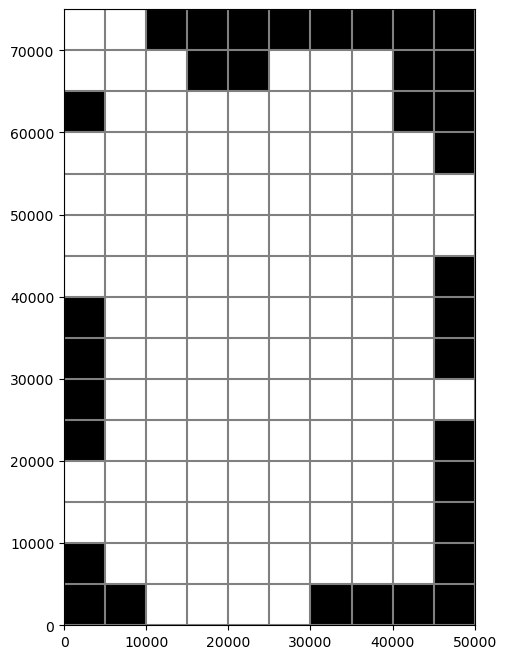

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m)
quadmesh = mapview.plot_ibound()
linecollection = mapview.plot_grid()

Read the ```irunbnd``` array from an external file.

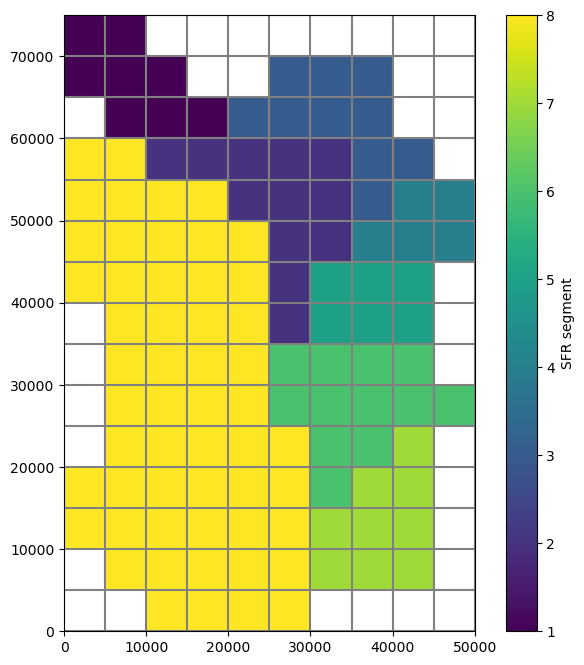

In [7]:
irnbndpth = proj_root / "examples" / "data" / "uzf_examples" / "irunbnd.dat"
irunbnd = np.loadtxt(irnbndpth)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m)
irunbndplt = mapview.plot_array(irunbnd)
plt.colorbar(irunbndplt, ax=ax, label="SFR segment")
linecollection = mapview.plot_grid()

Define the ``vks`` (unsaturated zone vertical hydraulic conductivity) array.

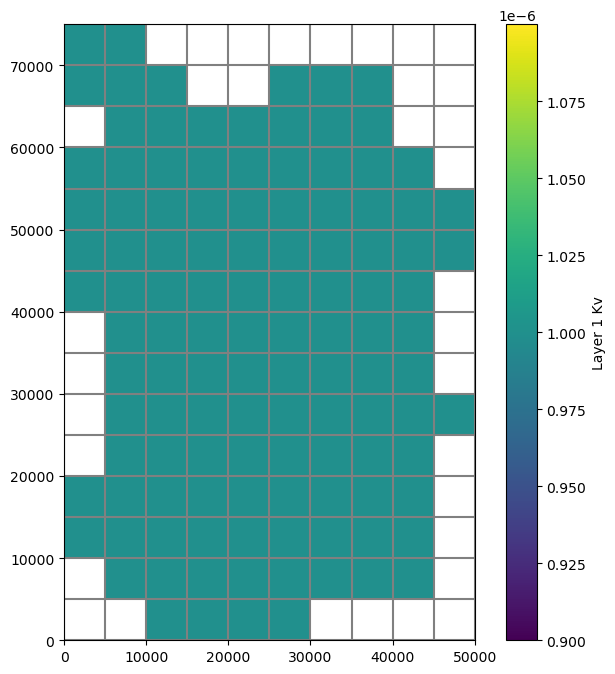

In [8]:
vksbndpth = proj_root / "examples" / "data" / "uzf_examples" / "vks.dat"
vks = np.loadtxt(vksbndpth)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m)
vksplt = mapview.plot_array(vks)
plt.colorbar(vksplt, ax=ax, label="Layer 1 Kv")
linecollection = mapview.plot_grid()

Define the `finf` array:
* load infiltration rates from a file into a 3D array
* `finf` can be submitted to FloPy as a 3D array, list of 2D arrays, list of numeric values, or single numeric value

In [9]:
m.nrow_ncol_nlay_nper

(15, 10, 1, 12)

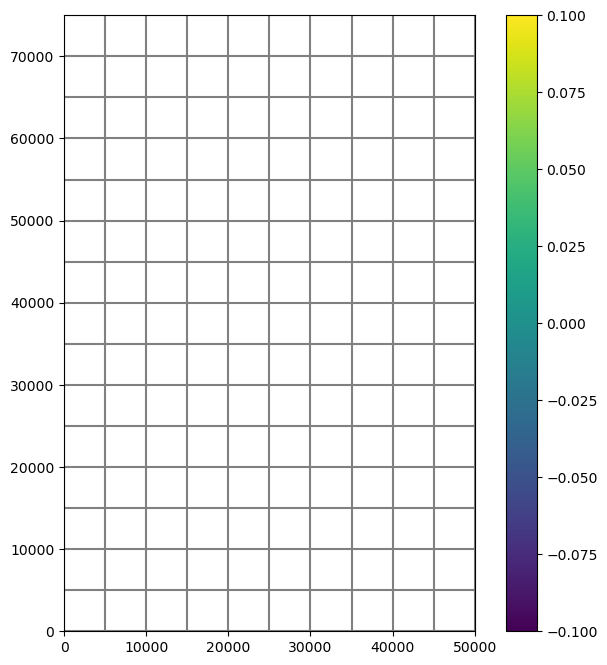

In [10]:
finf = np.loadtxt(
    proj_root / "examples" / "data" / "uzf_examples" / "finf.dat"
)
finf = np.reshape(finf, (m.nper, m.nrow, m.ncol))
finf = {i: finf[i] for i in range(finf.shape[0])}

# plot using PlotMapView
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m)
quadmesh = mapview.plot_array(finf[0])
plt.colorbar(quadmesh)
linecollection = mapview.plot_grid()

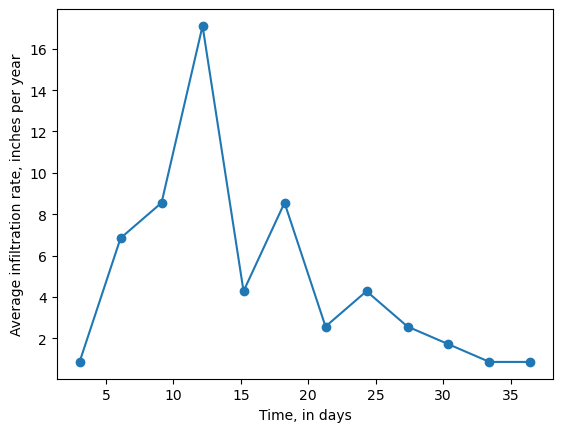

In [11]:
plt.plot(
    m.dis.perlen.array.cumsum() / 864600,
    [a.mean() * 86400 * 365 * 12 for a in finf.values()],
    marker="o",
)
plt.xlabel("Time, in days")
plt.ylabel("Average infiltration rate, inches per year");

Define `extwc` (extinction water content) array.

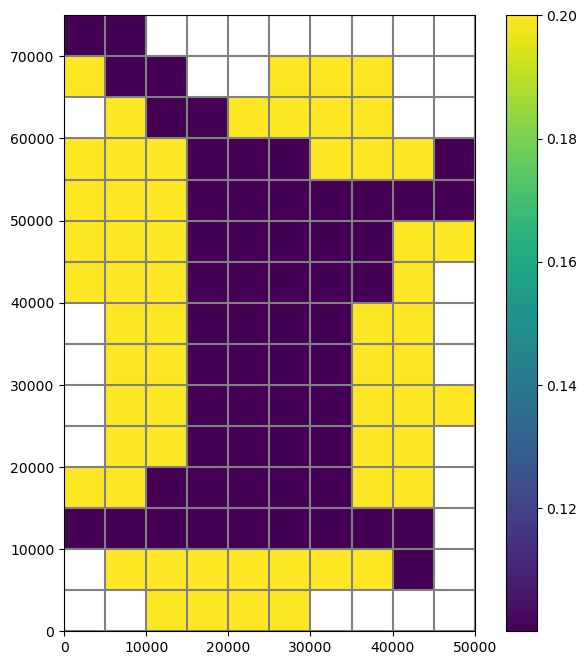

In [12]:
extwc = np.loadtxt(
    proj_root / "examples" / "data" / "uzf_examples" / "extwc.dat"
)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m)
quadmesh = mapview.plot_array(extwc)
plt.colorbar(quadmesh)
linecollection = mapview.plot_grid()

### Set up the gages (observation points)
* supplied as a dictionary keyed by `IFTUNIT`
* A positive value [of `IFTUNIT`] is for output of individual cells whereas a negative value is for output that is summed over all model cells. 
* values are a list of `[IUZROW, IUZCOL, IFTUNIT, IUZOPT]`
* `IUZROW` and `IUZCOL` are zero based

In [13]:
uzgag = {
    -68: [-68],
    65: [
        2,
        5,
        65,
        1,
    ],  # Print time, head, uz thickness and cum. vols of infiltration, recharge, storage, change in storage and ground-water discharge to land surface.
    66: [
        5,
        2,
        66,
        2,
    ],  # Same as option 1 except rates of infiltration, recharge, change in storage, and ground-water discharge also are printed.
    67: [9, 4, 67, 3],
}  # Prints time, ground-water head, thickness of unsaturated zone, followed by a series of depths and water contents in the unsaturated zone.

Make the UZF package.

In [14]:
uzf = flopy.modflow.ModflowUzf1(
    m,
    nuztop=1,
    iuzfopt=1,
    irunflg=1,
    ietflg=1,
    ipakcb=0,
    iuzfcb2=61,  # binary output of recharge and groundwater discharge
    ntrail2=25,
    nsets=20,
    surfdep=1.0,
    uzgag=uzgag,
    iuzfbnd=m.bas6.ibound.array,
    irunbnd=irunbnd,
    vks=vks,  # saturated vertical hydraulic conductivity of the uz
    finf=finf,  # infiltration rates
    eps=3.5,  # Brooks-Corey relation of water content to hydraulic conductivity (epsilon)
    thts=0.35,  # saturated water content of the uz in units of volume of water to total volume
    pet=5.000000e-08,  # potential ET
    extdp=15.0,  # ET extinction depth(s)
    extwc=extwc,  # extinction water content below which ET cannot be removed from the unsaturated zone
    unitnumber=19,
)

Write model input files.

In [15]:
m.write_input()

Run the model.

In [16]:
success, buff = m.run_model()
assert success, f"{m.name} failed to run"

FloPy is using the following executable to run the model: ../../../../../../Users/aleaf/Documents/software/modflow_exes/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: UZFtest2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/05/01 21:57:32

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress

 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Wa

 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.


 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.


 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    13    Ground-Wa

 Solving:  Stress period:     6    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     6    Ground-Water Flow Eqn.


 Solving:  Stress period:     7    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    13    Ground-Water Flow Eqn.


 Solving:  Stress period:     7    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     8    Ground-Water Flow Eqn.


 Solving:  Stress period:     8    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    14    Ground-Water Flow Eqn.


 Solving:  Stress period:     8    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     7    Ground-Water Flow Eqn.


 Solving:  Stress period:     9    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    13    Ground-Water Flow Eqn.


 Solving:  Stress period:     9    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     5    Ground-Water Flow Eqn.


 Solving:  Stress period:    10    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    12    Ground-Water Flow Eqn.


 Solving:  Stress period:    10    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     2    Ground-Water Flow Eqn.


 Solving:  Stress period:    11    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     9    Ground-Water Flow Eqn.


 Solving:  Stress period:    11    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    13    Ground-Water Flow Eqn.


 Solving:  Stress period:    11    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     3    Ground-Water Flow Eqn.


 Solving:  Stress period:    12    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    10    Ground-Water Flow Eqn.


 Solving:  Stress period:    12    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    14    Ground-Water Flow Eqn.


 Solving:  Stress period:    12    Time step:    15    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/05/01 21:57:37
 Elapsed run time:  4.293 Seconds

  Normal termination of simulation


## Inspecting results

First, look at the budget output.

In [17]:
fpth = path / "UZFtest2.uzfcb2.bin"
avail = os.path.isfile(fpth)
if avail:
    uzfbdobjct = flopy.utils.CellBudgetFile(fpth)
    uzfbdobjct.list_records()
else:
    print('"{}" is not available'.format(fpth))

(1, 1, b'           GW ET', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 1, b'    UZF RECHARGE', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 1, b' SURFACE LEAKAGE', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 1, b'       HORT+DUNN', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 1, b'  STORAGE CHANGE', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 2, b'           GW ET', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(1, 2, b'    UZF RECHARGE', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(1, 2, b' SURFACE LEAKAGE', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(1, 2, b'       HORT+DUNN', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(1, 2, b'  STORAGE CHANGE', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(5, 2, b'           GW ET', 10, 15, -1, 4, 121100.21, 504971.6, 313297

(5, 8, b'    UZF RECHARGE', 10, 15, -1, 4, 121100.21, 504971.6, 18900966., b'', b'', b'', b'')
(5, 8, b' SURFACE LEAKAGE', 10, 15, -1, 4, 121100.21, 504971.6, 18900966., b'', b'', b'', b'')
(5, 8, b'       HORT+DUNN', 10, 15, -1, 4, 121100.21, 504971.6, 18900966., b'', b'', b'', b'')
(5, 8, b'  STORAGE CHANGE', 10, 15, -1, 4, 121100.21, 504971.6, 18900966., b'', b'', b'', b'')
(10, 8, b'           GW ET', 10, 15, -1, 4, 195033.11, 1318233.4, 19714228., b'', b'', b'', b'')
(10, 8, b'    UZF RECHARGE', 10, 15, -1, 4, 195033.11, 1318233.4, 19714228., b'', b'', b'', b'')
(10, 8, b' SURFACE LEAKAGE', 10, 15, -1, 4, 195033.11, 1318233.4, 19714228., b'', b'', b'', b'')
(10, 8, b'       HORT+DUNN', 10, 15, -1, 4, 195033.11, 1318233.4, 19714228., b'', b'', b'', b'')
(10, 8, b'  STORAGE CHANGE', 10, 15, -1, 4, 195033.11, 1318233.4, 19714228., b'', b'', b'', b'')
(15, 8, b'           GW ET', 10, 15, -1, 4, 314102.8, 2627999.8, 21023994., b'', b'', b'', b'')
(15, 8, b'    UZF RECHARGE', 10, 15, -1

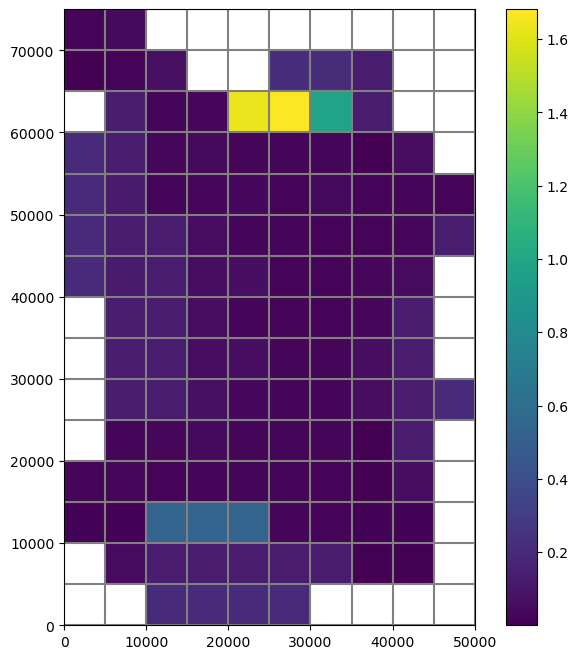

In [18]:
if success and avail:
    r = uzfbdobjct.get_data(text="UZF RECHARGE")
    et = uzfbdobjct.get_data(text="GW ET")

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    mapview = flopy.plot.PlotMapView(model=m)
    quadmesh = mapview.plot_array(r[6])
    plt.colorbar(quadmesh)
    linecollection = mapview.plot_grid()

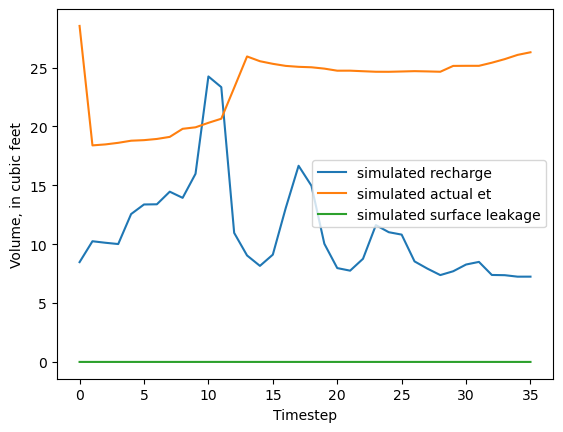

In [19]:
if avail:
    rtot = [rp.sum() for rp in r]
    ettot = [etp.sum() for etp in et]
    sltot = [sl.sum() for sl in uzfbdobjct.get_data(text="SURFACE LEAKAGE")]

    plt.plot(rtot, label="simulated recharge")
    plt.plot(np.abs(ettot), label="simulated actual et")
    plt.plot(np.abs(sltot), label="simulated surface leakage")
    plt.xlabel("Timestep")
    plt.ylabel("Volume, in cubic feet")
    plt.legend()

Look at the gages.

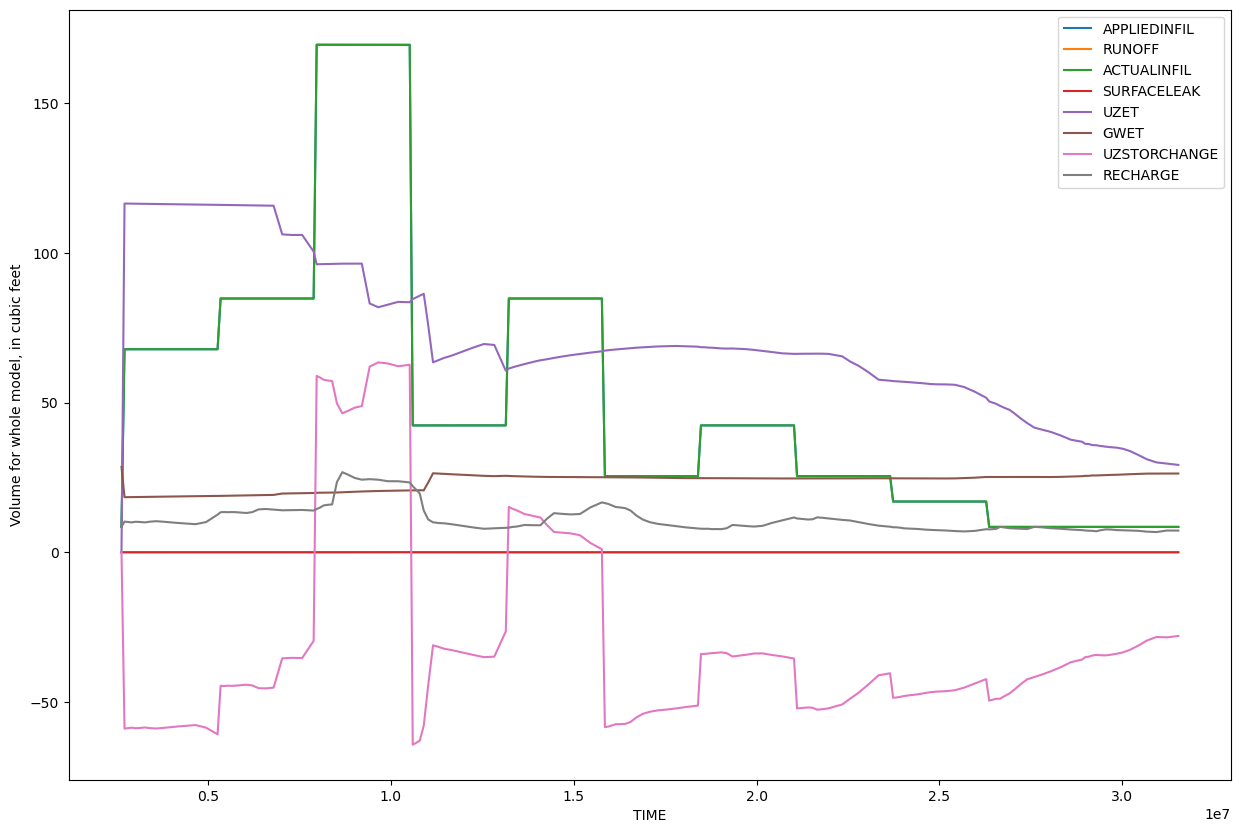

In [20]:
fpth = path / "UZFtest2.uzf68.out"
avail = os.path.isfile(fpth)
if avail:
    dtype = [
        ("TIME", float),
        ("APPLIED-INFIL", float),
        ("RUNOFF", float),
        ("ACTUAL-INFIL", float),
        ("SURFACE-LEAK", float),
        ("UZ-ET", float),
        ("GW-ET", float),
        ("UZSTOR-CHANGE", float),
        ("RECHARGE", float),
    ]
    # read data from file
    df = np.genfromtxt(fpth, skip_header=3, dtype=dtype)
    # convert numpy recarray to pandas dataframe
    df = pd.DataFrame(data=df)
    # set index to the time column
    df.set_index(["TIME"], inplace=True)
    # plot the data
    ax = df.plot(legend=False, figsize=(15, 10))
    patches, labels = ax.get_legend_handles_labels()
    ax.legend(patches, labels, loc=1)
    ax.set_ylabel("Volume for whole model, in cubic feet")

Plot water content profile through time at row 10, column 5.

In [21]:
fpth = path / "UZFtest2.uzf67.out"
avail = os.path.isfile(fpth)
if avail:
    data = []
    with open(fpth) as input:
        for i in range(3):
            next(input)
        for line in input:
            line = line.strip().split()
            if len(line) == 6:
                layer = int(line.pop(0))
                time = float(line.pop(0))
                head = float(line.pop(0))
                uzthick = float(line.pop(0))
            depth = float(line.pop(0))
            watercontent = float(line.pop(0))
            data.append([layer, time, head, uzthick, depth, watercontent])

In [22]:
if avail:
    df3 = pd.DataFrame(
        data,
        columns=["layer", "time", "head", "uzthick", "depth", "watercontent"],
    )
    df3.head(41)

In [23]:
if avail:
    wc = df3.watercontent.values.reshape(len(df3.time.unique()), 40).T
    wc = pd.DataFrame(wc, columns=df3.time.unique(), index=df3.depth[0:40])
    wc.head()

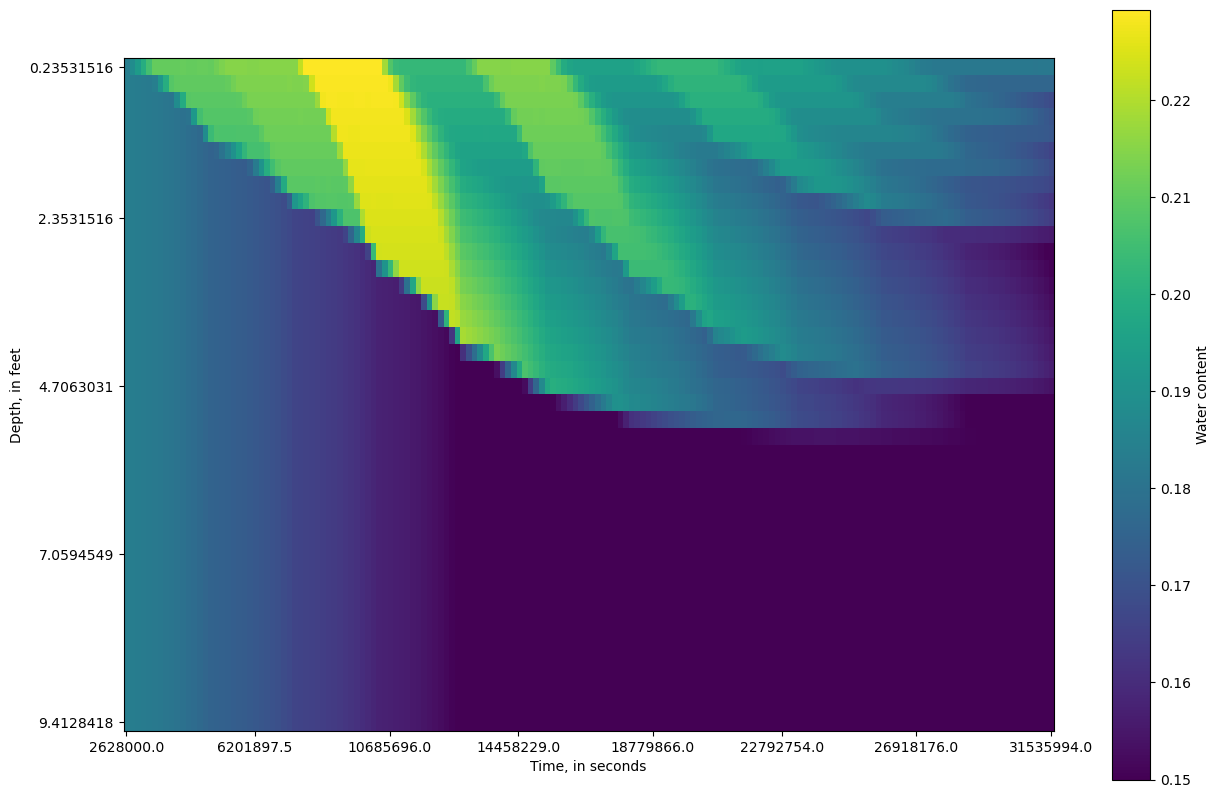

In [24]:
if avail:
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.imshow(wc, interpolation="None")
    ax.set_aspect(3)
    r, c = wc.shape
    xcol_locs = np.linspace(0, c - 1, 8, dtype=int)
    ycol_locs = np.linspace(0, r - 1, 5, dtype=int)
    ax.set_xticks(xcol_locs)

    xlabels = wc.columns
    ax.set_xticklabels(xlabels[xcol_locs])
    ax.set_ylabel("Depth, in feet")
    ax.set_yticks(ycol_locs)
    ax.set_yticklabels(wc.index[ycol_locs])
    ax.set_xlabel("Time, in seconds")
    plt.colorbar(label="Water content")

Clean up the temporary directory.

In [25]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass